[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F4_decision_trees.ipynb)

# Decision Trees

In this notebook we are going to use decision trees to classify handwritten digits.

We start as before with loading the data set.

In [1]:
from torchvision.datasets import MNIST

In [2]:
data = MNIST("data", download=True)
X = data.data.reshape(-1, data.data.shape[-2]*data.data.shape[-1]).numpy()
y = data.targets.numpy()

In [3]:
from sklearn.model_selection import train_test_split

But this time we want to split it into three data sets: training (60%), validation (20%), and testing (20%).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, shuffle=True, random_state=42)

In [5]:
X_train.shape, X_val.shape, X_test.shape

((36000, 784), (12000, 784), (12000, 784))

Here the validation data set is used to tune the hyperparameters of the model, while the test data set is used to evaluate the final model.

We again start by doing principal component analysis on our training, test, and validation data sets. Note, that we only use the training data set to compute the transformation.

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA()
Y_train = pca.fit_transform(X_train)
Y_val = pca.transform(X_val)
Y_test = pca.transform(X_test)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.dpi"] = 150

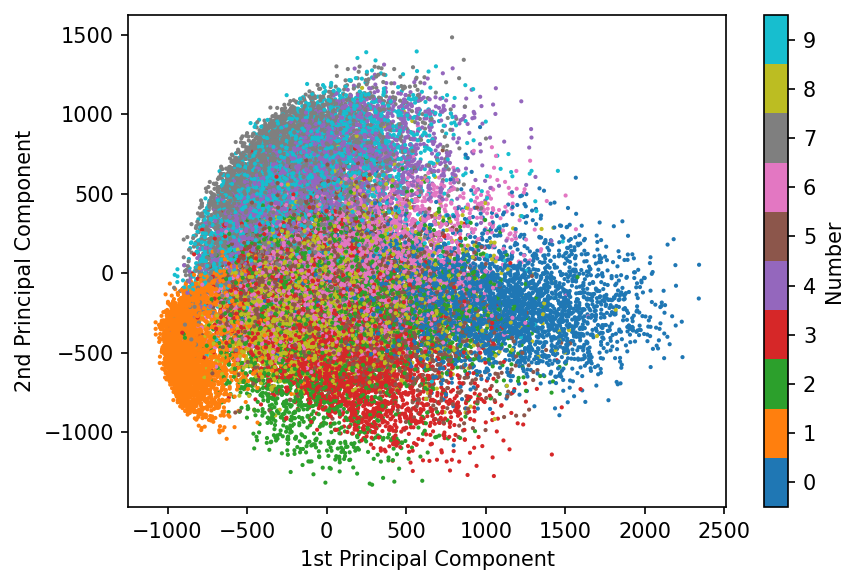

In [9]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=y_train, cmap="tab10", vmin=-0.5, vmax=9.5, s=1)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(np.arange(10))
cbar.set_label("Number")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

As an example, we are now trying to identify the "ones" on the lower left-hand side of the plot from all the other digits.  
We are assuming we can do so by only looking at the first principal component.

We are scanning different thresholds for the first principal components and compute the rates of true poositives and flase positive as a performance measure to try to find the optimal value for this treshold.

In [10]:
d = 1
Nt = 100
threshold = np.linspace(Y_train[:, 0].min(), Y_train[:, 0].max(), Nt)
FPR = np.empty(Nt)
TPR = np.empty(Nt)
for i, thr in enumerate(threshold):
    TP = (Y_train[y_train==d][:, 0]<=thr).sum()
    TN = (Y_train[y_train!=d][:, 0]>thr).sum()
    FP = (Y_train[y_train!=d][:, 0]<=thr).sum()
    FN = (Y_train[y_train==d][:, 0]>thr).sum()
    TPR[i] = TP/(TP+FN)
    FPR[i] = FP/(TN+FP)

These can be plotted on an receiver operating characteristic (ROC) curve, where every point represents one possible threshold value.

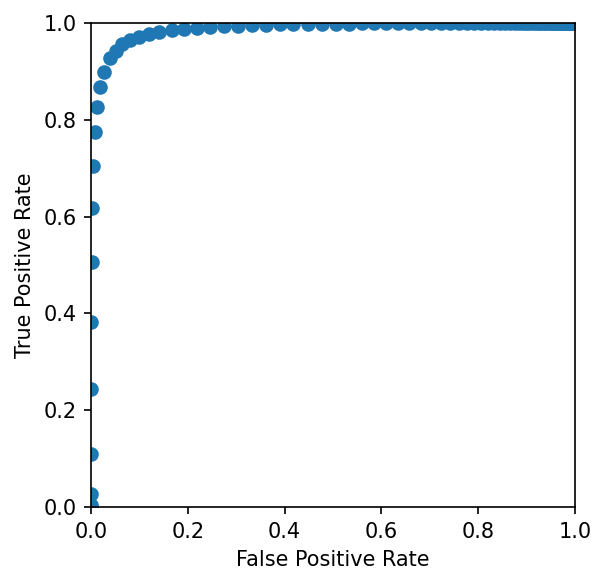

In [11]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.plot(FPR, TPR, "o")
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.tight_layout()

A perfect threshold value would have 0% false positives and 100% true positives. We are therefore selecting the threshold value that is closest to the (0, 1) coordinate.

In [12]:
thr_1 = threshold[(np.sqrt((FPR-0)**2 + (TPR-1)**2)).argmin()]

In [13]:
msg = "The threshold value in the first principal component is {:4.1f}.".format(thr_1)
print(msg)

The threshold value in the first principal component is -592.0.


We can plot all points that are selected by this threshold.

In [14]:
cond_1 = Y_train[:, 0] <= thr_1

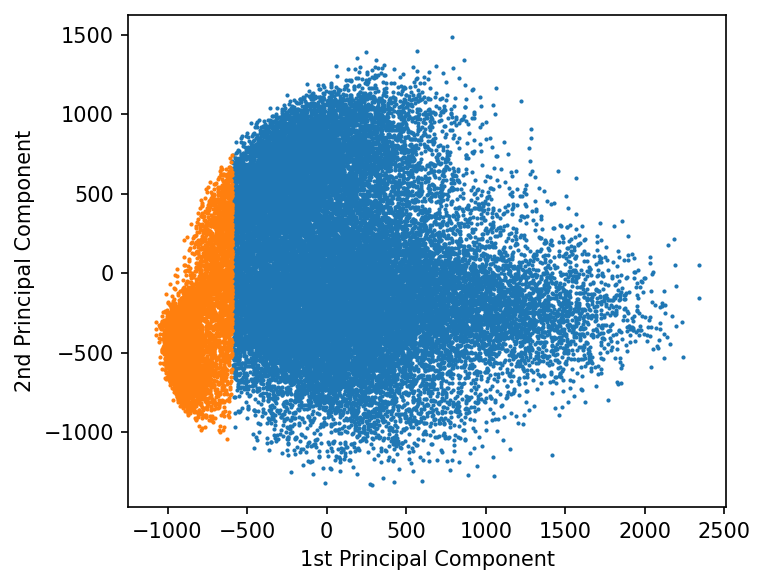

In [15]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Y_train[~cond_1][:, 0], Y_train[~cond_1][:, 1], c="C0", s=1)
plot = ax.scatter(Y_train[cond_1][:, 0], Y_train[cond_1][:, 1], c="C1", s=1)
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

We can do the same now for the second principal component.

In [16]:
d = 0
Nt = 100
threshold = np.linspace(Y_train[:, 1].max(), Y_train[:, 1].min(), Nt)
FPR = np.empty(Nt)
TPR = np.empty(Nt)
for i, thr in enumerate(threshold):
    TP = (Y_train[cond_1][y_train[cond_1]==d][:, 1]<=thr).sum()
    TN = (Y_train[cond_1][y_train[cond_1]!=d][:, 1]>thr).sum()
    FP = (Y_train[cond_1][y_train[cond_1]!=d][:, 1]<=thr).sum()
    FN = (Y_train[cond_1][y_train[cond_1]==d][:, 1]>thr).sum()
    TPR[i] = TP/(TP+FN)
    FPR[i] = FP/(TN+FP)

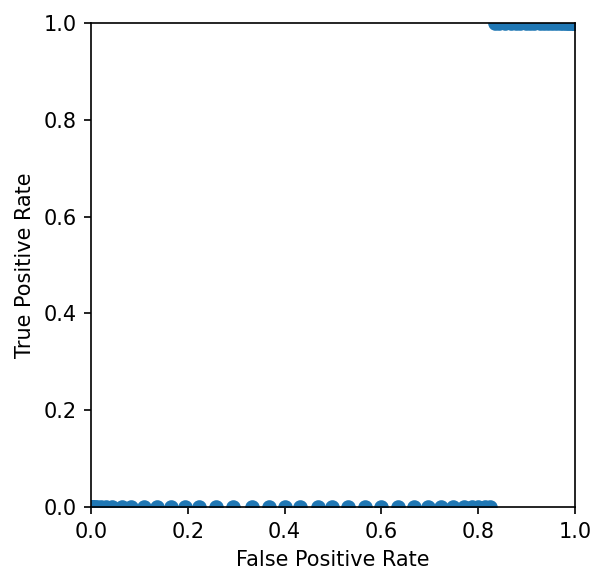

In [17]:
fig,ax = plt.subplots()
ax.set_aspect(1)
ax.plot(FPR, TPR, "o")
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.tight_layout()

We can again compute the optimal threshold value.

In [18]:
thr_2 = threshold[(np.sqrt((FPR-0)**2 + (TPR-1)**2)).argmin()]

In [19]:
msg = "The threshold value in the second principal component is {:3.1f}.".format(thr_2)
print(msg)

The threshold value in the second principal component is 62.1.


In [20]:
cond_2 = Y_train[:, 1] <= thr_2

In [21]:
condition_train = np.logical_and(Y_train[:, 0] <= thr_1, Y_train[:, 1] <= thr_2)
condition_test  = np.logical_and(Y_test[:, 0]  <= thr_1, Y_test[:, 1]  <= thr_2)

The data points that we selected with this method are plotted here.

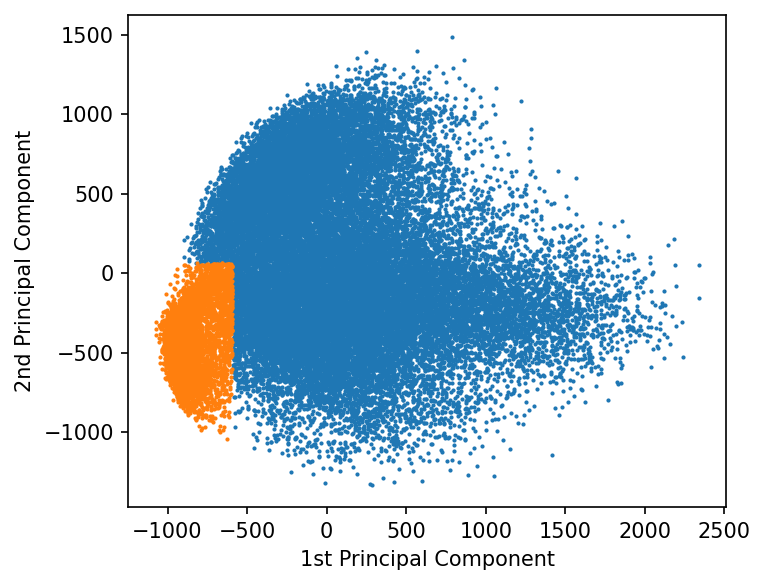

In [22]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Y_train[~condition_train][:, 0], Y_train[~condition_train][:, 1], c="C0", s=1)
plot = ax.scatter(Y_train[condition_train][:, 0], Y_train[condition_train][:, 1], c="C1", s=1)
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

And we can evaulate the overall performance in identifying fours in the training and test data sets. 

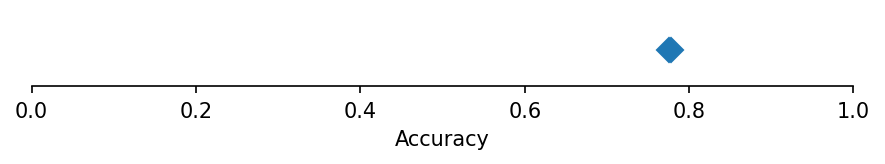

In [23]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(((y_train[condition_train]==d).sum()+(y_train[~condition_train]!=d).sum())/len(y_train), 0, "D", markersize=8, fillstyle="full", c="C0")
ax.plot(((y_test[condition_test]==d).sum()+(y_test[~condition_test]!=d).sum())/len(y_test), 0, "D", markersize=8, fillstyle="none", c="C0")
ax.set_xlim(0., 1)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
fig.tight_layout()

Actual decision tree algorithms work slightly different and the previous method should only be considered as a simplyfied example.

`sklearn` provides us with methods for creating decision trees.  
Note that we are using the actual data and not the principal components in this first example.

Decision trees are considered **supervised learning**, since the labels of the data are used for the fit.

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
tree_full = DecisionTreeClassifier().fit(X_train, y_train)

We can predict the output of the decision tree on our training and validation data set.

In [26]:
tree_full_pred_train = tree_full.predict(X_train)
tree_full_pred_val = tree_full.predict(X_val)

This returns us a list of labels that we can use for plotting.

In [27]:
tree_full_pred_train

array([5, 2, 1, ..., 1, 6, 5])

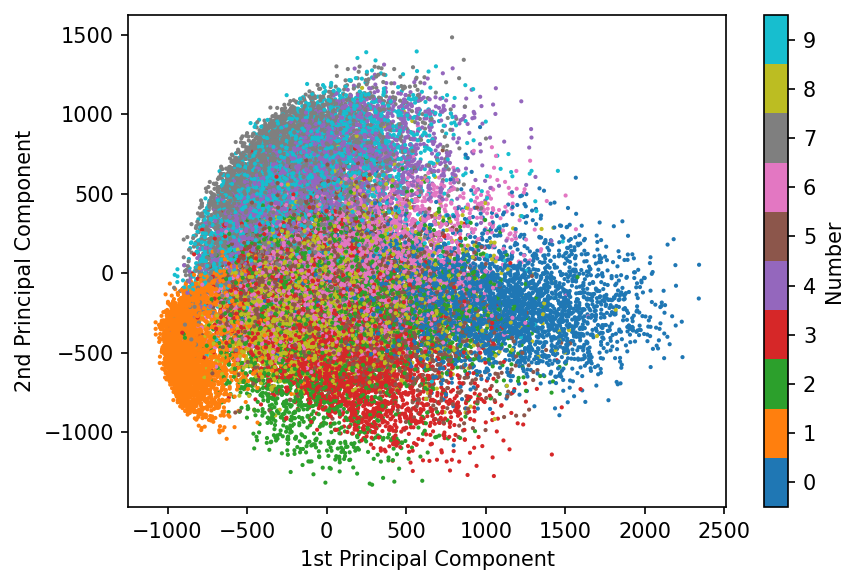

In [28]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=tree_full_pred_train, cmap="tab10", vmin=-0.5, vmax=9.5, s=1)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(np.arange(10))
cbar.set_label("Number")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

And as before we can visualize the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
cmat_tree_full_train = confusion_matrix(y_train, tree_full_pred_train, normalize="pred")
cmat_tree_full_val = confusion_matrix(y_val, tree_full_pred_val, normalize="pred")

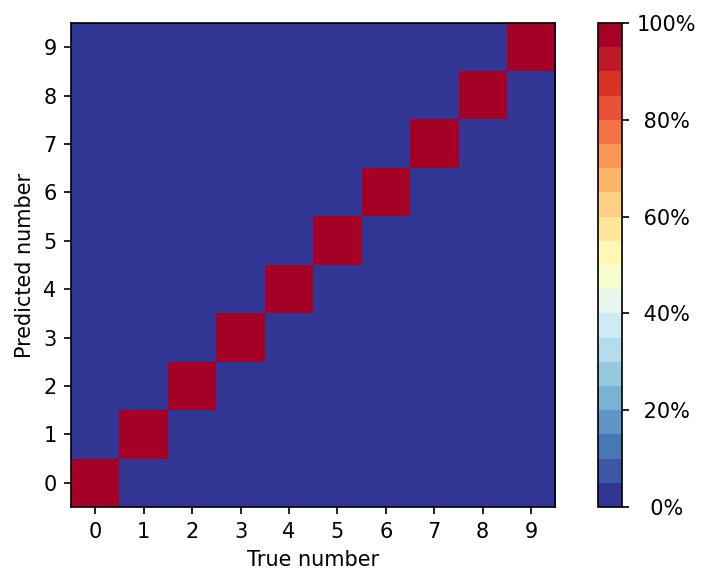

In [31]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_tree_full_train*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.ax.get_yticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

Our training data set has actually a perfect accuracy of 100%.

In [32]:
msg = "The decision tree has a performance of {:4.1f}% on the training data set.".format(tree_full.score(X_train, y_train)*100)
print(msg)

The decision tree has a performance of 100.0% on the training data set.


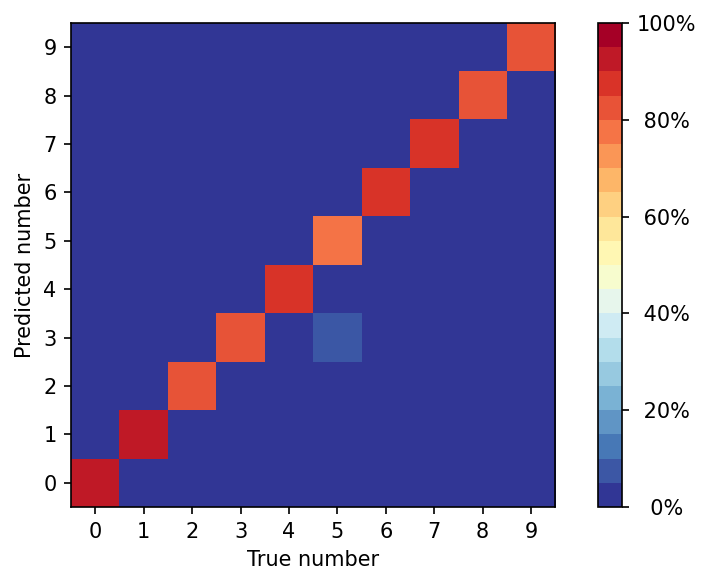

In [33]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_tree_full_val*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.ax.get_yticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

While the validation data set is significantly worse.

In [34]:
msg = "The decision tree has a performance of {:4.1f}% on the validation data set.".format(tree_full.score(X_val, y_val)*100)
print(msg)

The decision tree has a performance of 86.5% on the validation data set.


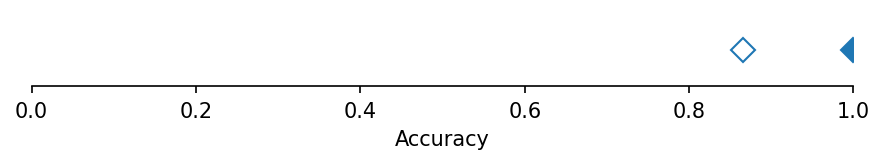

In [35]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(tree_full.score(X_train, y_train), 0, "D", markersize=8, fillstyle="full", c="C0")
ax.plot(tree_full.score(X_val, y_val), 0, "D", markersize=8, fillstyle="none", c="C0")
ax.set_xlim(0., 1.)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
fig.tight_layout()

The model is clearly overfitted, since the training data set performs significantly better than the validation training set.

What happened? We did not specify the maximum allowed depth of the tree. Therefore, the algorithm completely purified all leaves, which works fine for the training data set, but fails for the validation data set.  
We can do the same now, but we limit the maximum allowed depth of the tree. And this time we are training the model on the principal components.

In [36]:
tree_lim = DecisionTreeClassifier(max_depth=3).fit(Y_train, y_train)

In [37]:
tree_lim_pred_train = tree_lim.predict(Y_train)

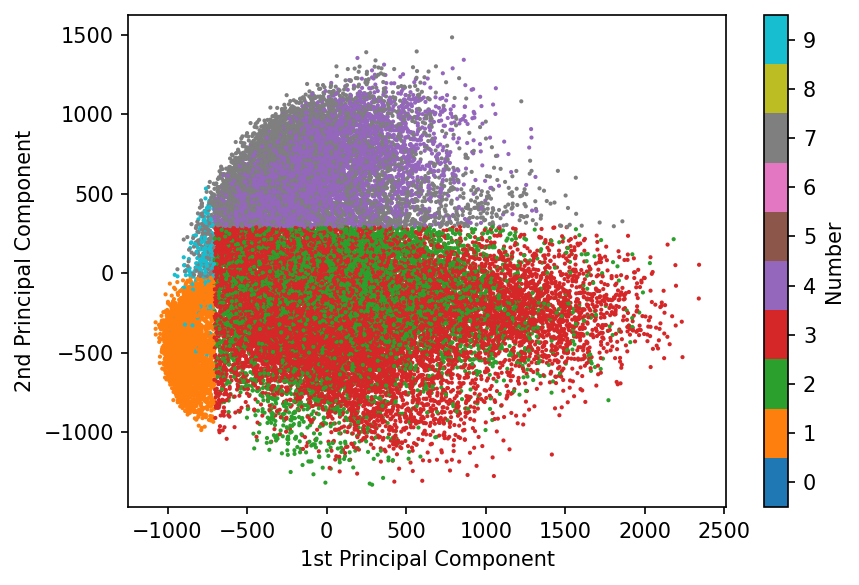

In [38]:
fig, ax = plt.subplots()
ax.set_aspect(1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=tree_lim_pred_train, cmap="tab10", vmin=-0.5, vmax=9.5, s=1)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(np.arange(10))
cbar.set_label("Number")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

We can now clearly see that the decision tree made its decisions along the principal component directions.  
The performance, however is significantly worse, since a depth of three in a binary tree creates at most 8 leaves, which is not enough for 10 digits.

In [39]:
cmat_tree_lim_train = confusion_matrix(y_train, tree_lim_pred_train, normalize="pred")

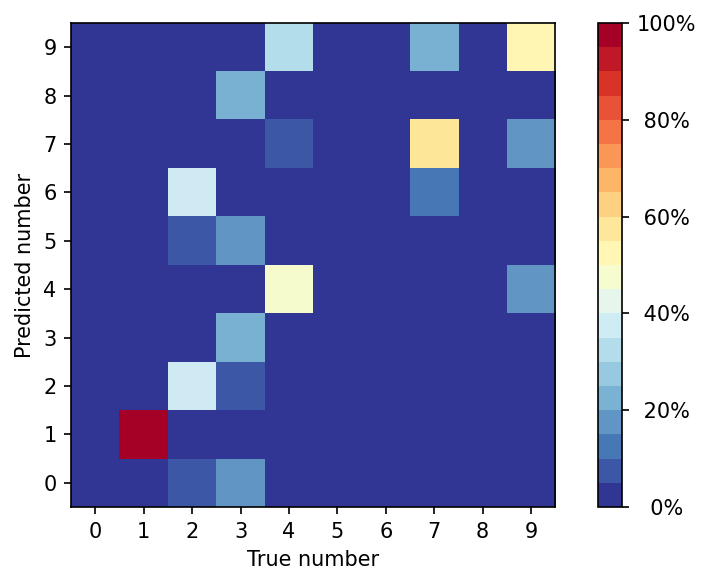

In [40]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_tree_lim_train*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.ax.get_yticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

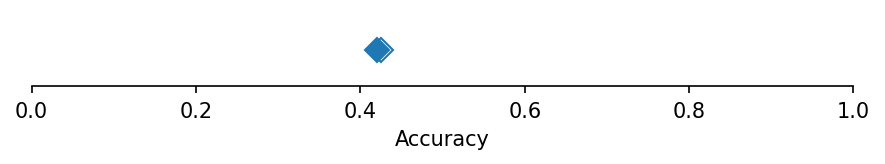

In [41]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(tree_lim.score(Y_train, y_train), 0, "D", markersize=8, fillstyle="full", c="C0")
ax.plot(tree_lim.score(Y_val, y_val), 0, "D", markersize=8, fillstyle="none", c="C0")
ax.set_xlim(0., 1.)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
fig.tight_layout()

We now need to find the optimal value of tree depth, that has the best performance without overfitting the model. 
For this, we run a grid of decision trees of different maximum allowed depths.

In [42]:
max_depth = np.arange(2, 21, 2)
score_train = np.empty_like(max_depth, dtype=float)
score_val = np.empty_like(max_depth, dtype=float)
for i, md in enumerate(max_depth):
    tree_lim = DecisionTreeClassifier(max_depth=md).fit(Y_train, y_train)
    score_train[i] = tree_lim.score(Y_train, y_train)
    score_val[i]  = tree_lim.score(Y_val, y_val)

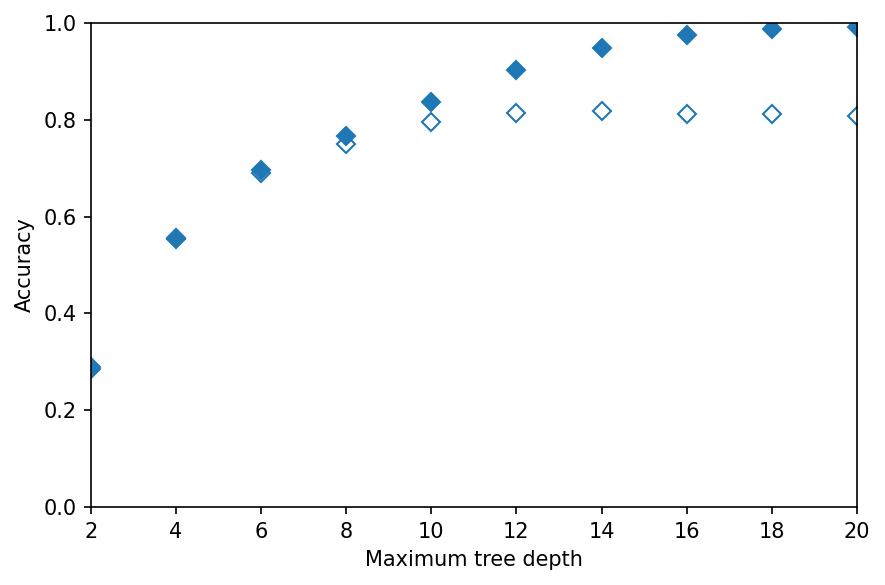

In [43]:
fig, ax = plt.subplots()
ax.plot(max_depth, score_train, "D", fillstyle="full", c="C0")
ax.plot(max_depth, score_val, "D", fillstyle="none", c="C0")
ax.set_xlim(max_depth[0], max_depth[-1])
ax.set_ylim(0., 1.)
ax.set_xlabel("Maximum tree depth")
ax.set_ylabel("Accuracy")
fig.tight_layout()

As we can see, the performance on the training data set improves with increasing tree depth, however the gap between the training and validation data sets become larger.

The overall performance is worse than in the previous example using k-means clustering.

To further improve the performance, we are going to create an ensemble of decisions trees (a forest) with low tree depths, which are each only trained on subsets of the training set. We are then consulting all trees for the classification and use a majority vote to decide on the digit.

`sklearn` has a method for this.  
We are creating a forest with 100 trees, where each tree was trained on a subset of 100 samples from the training set. We keep the maximum tree depth variable to find the optimal hyper-parameters.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
max_depth = np.arange(2, 21, 2)
score_forest_train = np.empty_like(max_depth, dtype=float)
score_forest_val = np.empty_like(max_depth, dtype=float)
for i, md in enumerate(max_depth):
    forest = RandomForestClassifier(max_depth=md, max_samples=5_000).fit(Y_train, y_train)
    score_forest_train[i] = forest.score(Y_train, y_train)
    score_forest_val[i]  = forest.score(Y_val, y_val)

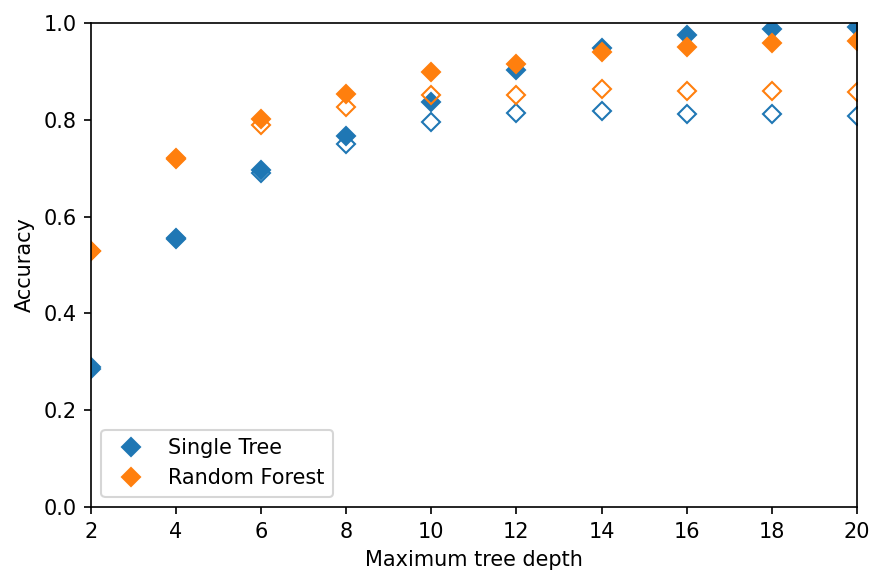

In [46]:
fig, ax = plt.subplots()
ax.plot(max_depth, score_train, "D", fillstyle="full", c="C0", label="Single Tree")
ax.plot(max_depth, score_val, "D", fillstyle="none", c="C0")
ax.plot(max_depth, score_forest_train, "D", fillstyle="full", c="C1", label="Random Forest")
ax.plot(max_depth, score_forest_val, "D", fillstyle="none", c="C1")
ax.set_xlim(max_depth[0], max_depth[-1])
ax.set_ylim(0., 1.)
ax.set_xlabel("Maximum tree depth")
ax.set_ylabel("Accuracy")
ax.legend()
fig.tight_layout()

The performance of the random forest on the validation data set is significantly better than the single tree and the gap between training and validation data set remains smaller even for larger tree depths.

We now consider a maximum tree depth of 16 as optimal parameters as compromise between best score and overtraining and run a final evaluation on our test data set.

In [47]:
tree = RandomForestClassifier(max_depth=16, max_samples=5_000).fit(Y_train, y_train)
score_train = tree.score(Y_train, y_train)
score_val = tree.score(Y_val, y_val)
score_test = tree.score(Y_test, y_test)

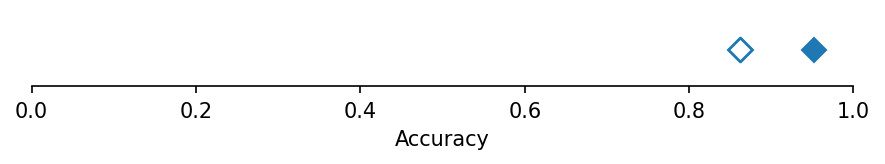

In [48]:
fig, ax = plt.subplots(figsize=(6., 1.2))
ax.plot(score_train, 0, "D", markersize=8, fillstyle="full", c="C0")
ax.plot(score_val, 0, "D", markersize=8, fillstyle="none", c="C0")
ax.plot(score_test, 0, "D", markersize=8, fillstyle="none", c="C0")
ax.set_xlim(0., 1)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
fig.tight_layout()

Here is the confusion matrix on the test data set.

In [49]:
forest_pred_test = forest.predict(Y_test)
cmat_forest_test = confusion_matrix(y_test, forest_pred_test, normalize="pred")

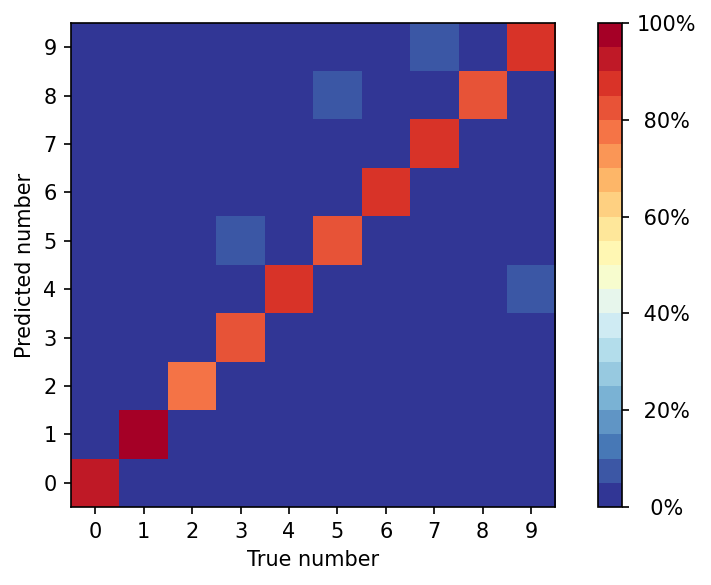

In [50]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("RdYlBu_r", 20)
plot = ax.imshow(cmat_forest_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.set_ticks(cbar.ax.get_yticks())
cbar.set_ticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

While for k-means clustering and a singe decision tree every sample was associated to exactly one label, we have a distribution in the case of a random forest. We can interpret this as an estimate of the probability of sample being a certain digit.

In [51]:
forest_prob_test = forest.predict_proba(Y_test)

In [52]:
def plot_prob(X, y, prob, i=None):
    width = 3.
    height = width/1.6
    if i is None:
        i = np.random.randint(0, len(X)-1)
    d = int(np.sqrt(X[0].shape[0]))
    fig = plt.figure(figsize=(3.*width, height))
    ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2)
    ax1.imshow(X[i, :].reshape((d, d)), cmap="Greys", vmax=X.max(), vmin=X.min())
    ax1.axis("off")
    ax1.set_title("Digit: {}".format(y[i]))
    ax2.bar(np.arange(10), prob[i, :]*100)
    ax2.set_ylim(0., 100)
    ax2.grid(axis="y")
    ax2.set_xticks(np.arange(10))
    ax2.set_title("Prediciton: {}".format(prob[i].argmax()))
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(["{:3.0f}%".format(p) for p in ax2.get_yticks()])
    fig.tight_layout()

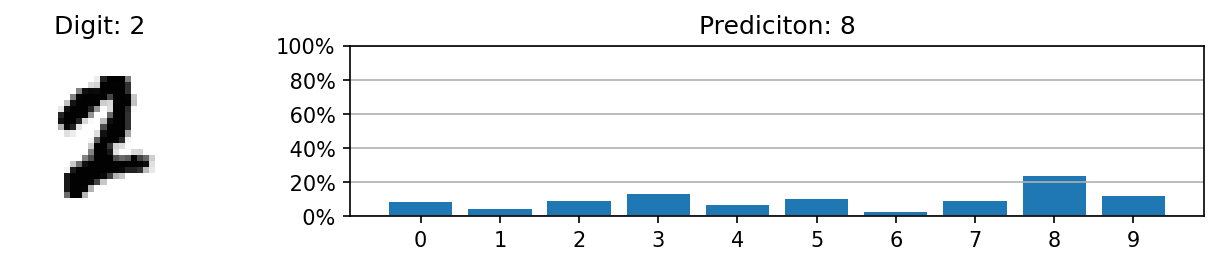

In [53]:
plot_prob(X_test, y_test, forest_prob_test)